In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import trange
from sklearn import datasets


In [4]:
# Load Iris Dataset for Testing on Real Data

iris = datasets.load_iris()

X = iris.data
Y = iris.target

In [5]:
# Define Global Parameters

NUM_FEATURES = 1000
NUM_SAMPLES = 1000
NUM_CLASSES = 50

In [6]:
# Steps 1 and 2

A = np.random.randn(NUM_SAMPLES, NUM_FEATURES)

X = np.random.randn(NUM_FEATURES, NUM_CLASSES)
W = np.random.randn(NUM_FEATURES, NUM_CLASSES) # additional weight matrix

E = np.random.randn(NUM_SAMPLES, NUM_CLASSES)

# Even though we'll use X in algorithms, we won't use it in the initialization of B
B = A.dot(W) + E

In [8]:
Y = np.argmax(B, axis=1) 

# Y one-hot encoding
# Set maximum value of each row to 1 and others to 0
Y_oh = (B == B.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_one_hot = np.zeros((NUM_SAMPLES, NUM_CLASSES))
Y_one_hot[np.arange(NUM_SAMPLES), Y] = 1

In [9]:
# Define Multiclass Logistic Regression Loss Function
def loss(X):
    first_term = (A * X.T[Y]).sum(axis=-1)
    # asterisk is element-wise multiplication

    second_term = np.log(np.exp(A.dot(X)).sum(axis=-1))
    # dot product is matrix multiplication since we are doing it across all classes 

    return (-first_term + second_term).sum()
    # summing across all samples

In [10]:
def gradient(X):
    AX = A.dot(X)
    # just perform matrix multiplication one time to reduce complexity
    soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    # keepdims is used to keep the dimensions of X to align with Y_oh
    return A.T.dot(soft_max - Y_oh)
    #    final dimensions should be NUM_FEATURES x NUM_CLASSES 

In [11]:
# Create copy of X to test different gradient algorithms
X_GD = X.copy()
X_BCGD_R = X.copy()
X_BCGD_GS = X.copy()

In [12]:
# Step 3A: Gradient Descent

# Set parameters for gradient descent
max_iter = 500
# static learning rate for now
learning_rate = 0.001

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # every iteration calculate gradient and update X
    X_GD -= learning_rate * gradient(X_GD)
    # calculate loss and accuracy every 1 iteration
    if i % 1 == 0:
        losses.append(loss(X_GD))
        times.append(time.time() - start_time)
        accuracies.append((Y == np.argmax(A.dot(X_GD), axis=1)).mean())

100%|██████████| 500/500 [00:15<00:00, 33.06it/s]


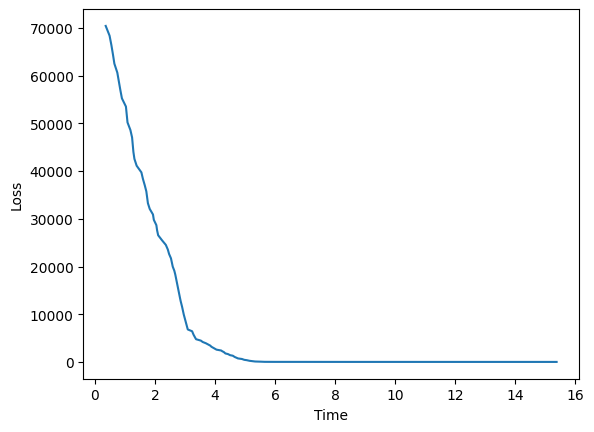

In [13]:
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

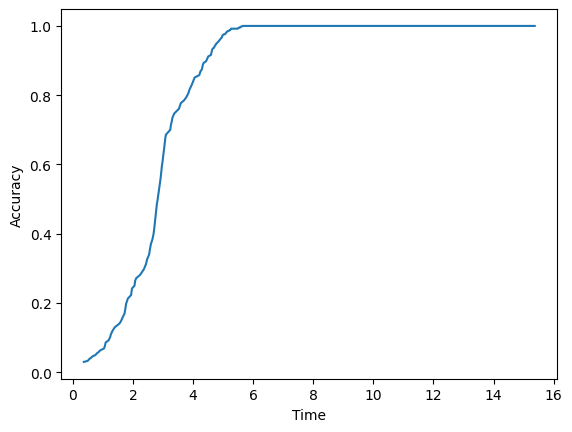

In [14]:
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [16]:
# Gradient for Block Coordinate Algorithms
# We define a block as a COLUMN of X, or a class
# Required params are weight matrix X and the block index

def gradient_bcgd(X, block):
    AX = A.dot(X)
    soft_max = np.exp(AX[:,block]) / np.exp(AX).sum(axis=-1)
    # only calculate the softmax and gradient for the block
    return A.T.dot(soft_max - Y_oh[:,block])


In [17]:
# Step 3B: BCGD with Randomized Block Selection

# Set parameters for BCGD with Randomized Block Selection
max_iter = 500
learning_rate = 0.001

bcgd_r_losses = []
bcgd_r_times = []
bcgd_r_accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # for every iteration, we iterate through all blocks to align with full gradient descent updates
    for j in range(NUM_CLASSES):
        # randomly select a block to update
        block = np.random.randint(0, NUM_CLASSES)
        # update the gradient just for the block
        X_BCGD_R[:, block] -= learning_rate * gradient_bcgd(X_BCGD_R, block)
    # append loss, time, accuracy 
    if i % 1 == 0:
        bcgd_r_losses.append(loss(X_BCGD_R))
        bcgd_r_times.append(time.time() - start_time)
        bcgd_r_accuracies.append((Y == np.argmax(A.dot(X_BCGD_R), axis=1)).mean())

100%|██████████| 500/500 [02:20<00:00,  3.55it/s]


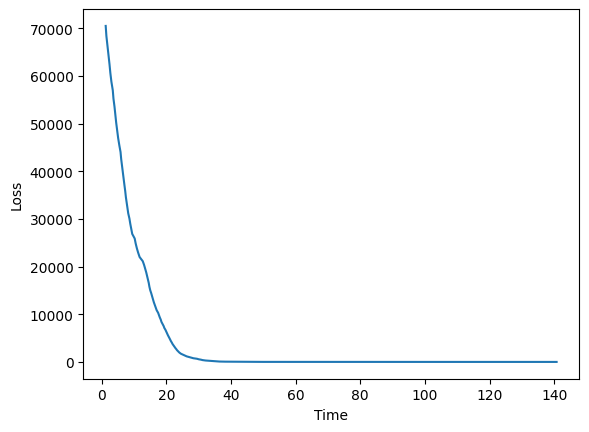

In [18]:
plt.plot(bcgd_r_times, bcgd_r_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

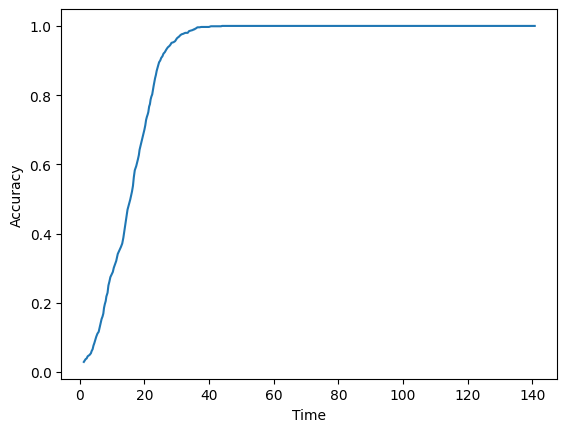

In [19]:
plt.plot(bcgd_r_times, bcgd_r_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [20]:
# Initial Attempt to calculate new gradient residual for BCGD with GS
def new_grad_residual(weights, gradient):
    AX = A.dot(weights)
    old_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    ws = weights - gradient
    AX = A.dot(ws)
    new_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    return A.T.dot(old_soft_max - new_soft_max)

In [21]:
# Step 3C: BCGD with GS Block Selection

# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_gs_losses = []
bcgd_gs_times = []
bcgd_gs_accuracies = []

grad = gradient(X_BCGD_GS)
start_time = time.time()

for i in trange(max_iter):
    for j in range(NUM_CLASSES):
        block = np.argmax(np.linalg.norm(grad))
        block_grad = grad[:,block]
        sparse_grad = np.zeros_like(grad)
        sparse_grad[:,block] = block_grad * learning_rate 
        new_grad_temp = new_grad_residual(X_BCGD_GS, sparse_grad) + grad
        X_BCGD_GS[:,block] -= learning_rate * block_grad
        grad = new_grad_temp
        
    if i % 1 == 0:
        bcgd_gs_losses.append(loss(X_BCGD_GS))
        bcgd_gs_times.append(time.time() - start_time)
        bcgd_gs_accuracies.append((Y == np.argmax(A.dot(X_BCGD_GS), axis=1)).mean())


  1%|          | 4/500 [00:03<07:04,  1.17it/s]/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_94015/2986827411.py:7: RuntimeWarning: overflow encountered in exp
  new_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_94015/2986827411.py:7: RuntimeWarning: invalid value encountered in divide
  new_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_94015/2986827411.py:4: RuntimeWarning: overflow encountered in exp
  old_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
/var/folders/6s/cxj5rgw54dsbpmz890jbgcx40000gp/T/ipykernel_94015/2986827411.py:4: RuntimeWarning: invalid value encountered in divide
  old_soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
100%|██████████| 500/500 [06:45<00:00,  1.23it/s]


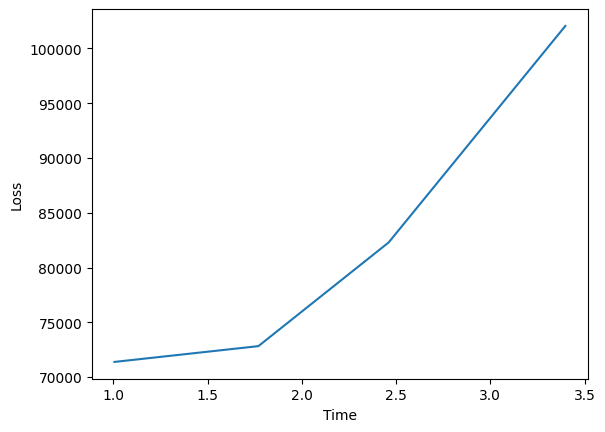

In [22]:
plt.plot(bcgd_gs_times, bcgd_gs_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()